# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

The scope of this exercise sheet is the recognition of handwritten digits from $0$ to $9$. For this purpose, in exercise 12.1, we simply train a deep neural network (DNN) on the MNIST dataset. Exercise 12.2 regards the implementation of a somewhat more sophistaced approach, namely a convolutional neural network (CNN). In Exercise 12.3, the trained CNN is tested on selfwritten digits that are not part of the MNIST dataset.

First of all, we import some Python libraries and load the MNIST dataset that containes $60000$ training images and $10000$ test images. In doing so, the training and test examples are converted such that each image is represented by a vector $\vec{x} \in [0, 1]^{784}$. The labels are given by $y \in {0, 1}^{10}$, where only the entry that classifies the corresponding image is $1$.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

seed = 0
np.random.seed(seed)

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)

# cast floats to single precision
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

### Exercise 12.1

Now, we implement the structure of our DNN. We include two hidden layers with $400$ and $100$ neurons. For both hidden layers, the relu activation function is used. The output layer applies the softmax function given that we have to deal with a classification task. Additional, dropout with a rate of $0.5$ is applied in order to reduce the risk of overfitting. 

In [7]:
def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def compile_model(opt):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=opt,
                  metrics=['acc'])
    return model

In the figure below, the accuracy and the loss of the neural network for both the training and the test set are plotted againts the number of epochs $N_{epochs}$ for different optimizers. All other parameters are fixed. For all optimizers, we go up to $N_{epochs}=10$ processed in batches of size $32$. All of the optimizers - except for Frtl - lead to increasing accuracies for increasing number of epochs $N_{epochs}$. Especially, Adam and Nadam converge rapidly to an accuracy on the test set of about 98 %.

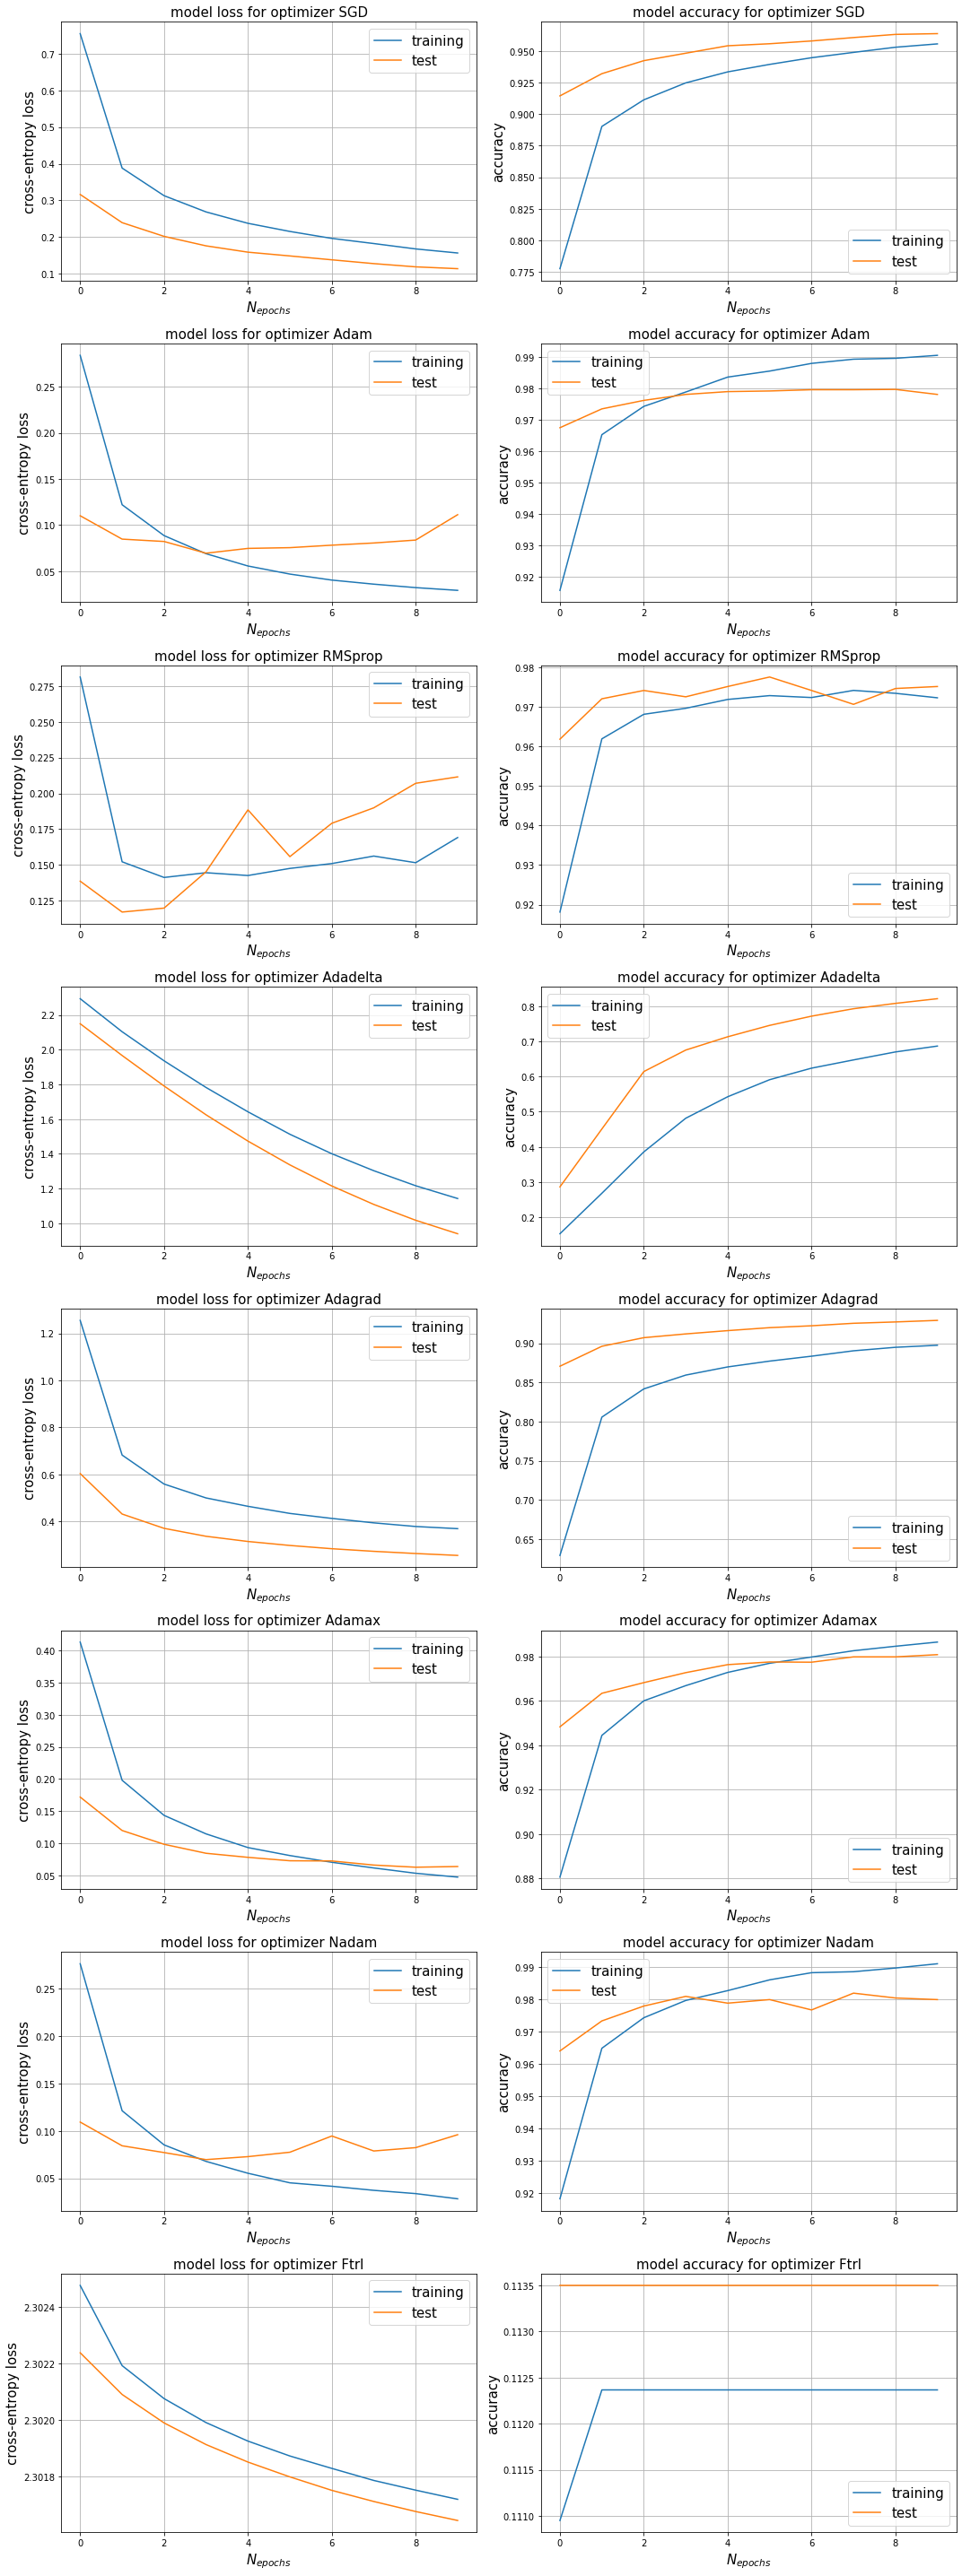

In [18]:
opt_list = ["SGD", "Adam", "RMSprop", "Adadelta", "Adagrad", "Adamax", "Nadam", "Ftrl"]

# training parameters
batch_size = 32
epochs = 10

fig, ax = plt.subplots(len(opt_list), 2, figsize=(15, 40))

for i, opt in enumerate(opt_list):
    
    # create the deep neural net
    model_DNN = compile_model(opt)

    # train DNN and store training info in history
    history = model_DNN.fit(X_train, Y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=False,
              validation_data=(X_test, Y_test))
    
    ax[i][0].plot(history.history['loss'], label="training")
    ax[i][0].plot(history.history['val_loss'], label="test")
    ax[i][0].set_xlabel("$N_{epochs}$", size=15)
    ax[i][0].set_ylabel("cross-entropy loss", size=15)
    ax[i][0].set_title("model loss for optimizer " + opt, size=15)
    ax[i][0].grid()
    ax[i][0].legend(fontsize=15)
    
    ax[i][1].plot(history.history['acc'], label="training")
    ax[i][1].plot(history.history['val_acc'], label="test")
    ax[i][1].set_xlabel("$N_{epochs}$", size=15)
    ax[i][1].set_ylabel("accuracy", size=15)
    ax[i][1].set_title("model accuracy for optimizer " + opt, size=15)
    ax[i][1].grid()
    ax[i][1].legend(fontsize=15)

plt.tight_layout()
plt.show()

### Exercise 12.2

Now, we want to improve the performance of our neural network. For this purpose, we substitute our deep neural network with a convolutional neural network. CNNs are common for applications concerning the recognition of images as they implement translational invariance. This means that digits are recognized well, no matter on what part of the image they are. A CNN implements translational invariance by using convolutional and pooling layers in its structure. These layers essential apply filters to the input data, and can be seen as a type of image preprocessing.

In the next cell of this Jupyter Notebook, we define the structure of our CNN. The first step of our CNN is a convolutional layer with a $5\times5$-kernel (size of filter) with ten filters, followed by a max-pooling layer. Then, we use another convolutional layer with the same kernel size, but with $16$ different filters, plus another max-pooling layer. The final part of our CNN consists of a Flatten-layer that reshapes the data, followed by a normal (dense) layer with $256$ neurons. Here, we apply dropout with a rate of $0.5$. The output layer contains ten neurons and applies the softmax activation function that gives a probability distribution about which digit is shown in a given image. For all the other layers, we use the relu activation function.

In [41]:
# reshape data for CNN
if keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
def create_CNN():
    
    # instantiate model
    model = Sequential()
    
    # add first convolutional layer with 10 filters (dimensionality of output space)
    model.add(Conv2D(10, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Conv2D(16, kernel_size=(5,5), 
                                  activation='relu'))
    model.add(keras.layers.MaxPooling2D())
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer="Adam",
                  metrics=['acc'])
    return model

The next step is to train our CNN. For this purpose, we use $N_{epochs}=10$ with a batch size of $32$ in combination with the Adam optimizer. Below, we plot the loss and the accuracy as a function of $N_{epochs}$ for both the trainig and the test examples. We observe how the accuracy increases with increasing number of epochs $N_{epochs}$. We reach an accuracy of up to 99.31 %, which is larger than the accuracy that we obtained with our DNN.

Epoch 1/10
1875/1875 [==============================] - 56s 29ms/step - loss: 0.4397 - acc: 0.8601 - val_loss: 0.0567 - val_acc: 0.9832
Epoch 2/10
1875/1875 [==============================] - 42s 23ms/step - loss: 0.0839 - acc: 0.9747 - val_loss: 0.0377 - val_acc: 0.9887
Epoch 3/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0572 - acc: 0.9826 - val_loss: 0.0346 - val_acc: 0.9891
Epoch 4/10
1875/1875 [==============================] - 39s 21ms/step - loss: 0.0433 - acc: 0.9867 - val_loss: 0.0351 - val_acc: 0.9891
Epoch 5/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0386 - acc: 0.9884 - val_loss: 0.0279 - val_acc: 0.9917
Epoch 6/10
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0314 - acc: 0.9906 - val_loss: 0.0278 - val_acc: 0.9902
Epoch 7/10
1875/1875 [==============================] - 47s 25ms/step - loss: 0.0282 - acc: 0.9904 - val_loss: 0.0267 - val_acc: 0.9919
Epoch 8/10
1875/1875 [==========================

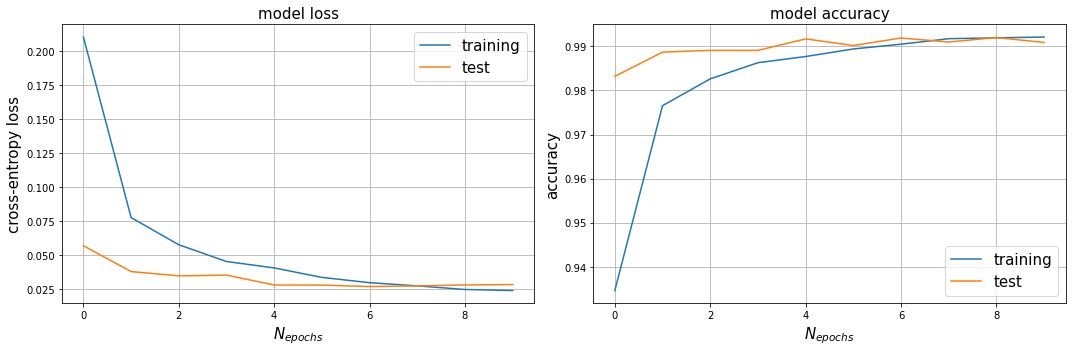

In [42]:
# training parameters
batch_size = 32
epochs = 10

# create the deep conv net
model_CNN = create_CNN()

# train CNN
history = model_CNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(history.history['loss'], label="training")
ax[0].plot(history.history['val_loss'], label="test")
ax[0].set_xlabel("$N_{epochs}$", size=15)
ax[0].set_ylabel("cross-entropy loss", size=15)
ax[0].set_title("model loss", size=15)
ax[0].grid()
ax[0].legend(fontsize=15)

ax[1].plot(history.history['acc'], label="training")
ax[1].plot(history.history['val_acc'], label="test")
ax[1].set_xlabel("$N_{epochs}$", size=15)
ax[1].set_ylabel("accuracy", size=15)
ax[1].set_title("model accuracy", size=15)
ax[1].grid()
ax[1].legend(fontsize=15)

plt.tight_layout()
plt.show()

### Exercise 12.3

Finally, we test our CNN that we trained in the last exercise on new handwritten digits that are not part of the MNIST test examples. As we can see below, our CNN classifies all of the ten images correctly.

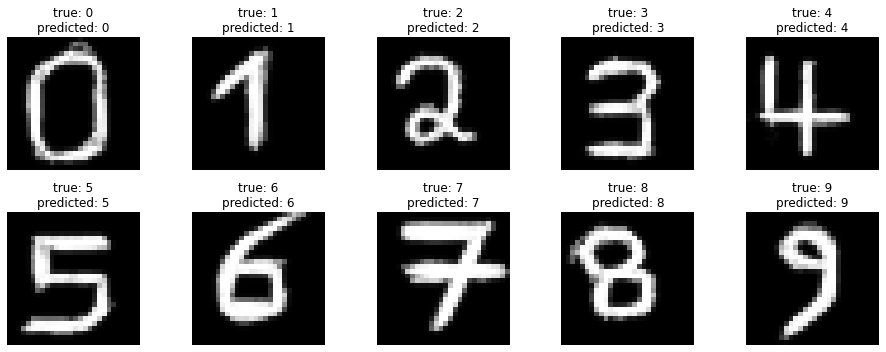

In [74]:
fig, ax = plt.subplots(2, 5, figsize=(13, 5))

for num in range(10):
    
    digit_filename = "./images/" + str(num) + ".png"
    digit_in = Image.open(digit_filename).convert('L')
    
    ydim, xdim = digit_in.size
    pix=digit_in.load()
    data = np.zeros((xdim, ydim))
    for j in range(ydim):
        for i in range(xdim):
            data[i,j]=pix[j,i]

    data /= 255
    
    # compute predicted label
    data = data.reshape(1, xdim, ydim, 1)
    pred = model_CNN.predict(data)
    data = data.reshape(xdim, ydim)
    pred = np.argmax(pred)
    
    row = 0
    true = num
    if num >= 5:
        row = 1
        num = num - 5
        
    ax[row, num].imshow(data, cmap='gray')
    ax[row, num].axis('off')
    ax[row, num].set_title("true: " + str(true) + "\npredicted: " + str(pred))

plt.tight_layout()
plt.show()